In [1]:
## import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from glob import glob
import os
# Dataset setup
dataset_path = "/kaggle/input/dataset/Dataset"
categories = ["glioma", "healthy", "meningioma"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced preprocessing with patch-based loading
class MRIDataset(Dataset):
    def __init__(self, hr_size=512, lr_size=256, augment=True):
        self.hr_size = hr_size
        self.lr_size = lr_size
        self.augment = augment
        self.image_paths = []

        for category in categories:
            self.image_paths.extend(sorted(glob(os.path.join(dataset_path, category, '*'))))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Data augmentation
        if self.augment:
            if np.random.rand() > 0.5:
                img = cv2.flip(img, 1)
            if np.random.rand() > 0.5:
                img = cv2.flip(img, 0)

        # Generate HR and LR pairs
        hr_img = cv2.resize(img, (self.hr_size, self.hr_size)).astype(np.float32) / 255.0
        lr_img = cv2.resize(img, (self.lr_size, self.lr_size), interpolation=cv2.INTER_CUBIC)
        lr_img = lr_img.astype(np.float32) / 255.0

        # Add channel dimension and convert to tensor
        # lr_img = torch.from_numpy(lr_img[np.newaxis, np.newaxis, :, :])  # [1, 1, 256, 256]
        lr_img = torch.from_numpy(lr_img[np.newaxis, :, :])  # shape: [1, H, W]
        # hr_img = torch.from_numpy(hr_img[np.newaxis, np.newaxis, :, :])    # [1, 1, 512, 512]
        hr_img = torch.from_numpy(hr_img[np.newaxis, :, :])  # shape: [1, H, W]

        return lr_img, hr_img

# Create dataloader
train_dataset = MRIDataset()
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)

In [2]:
print("Training Data: ", train_dataset)

Training Data:  <__main__.MRIDataset object at 0x7ea8c1055450>


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import ops

from itertools import repeat
import collections.abc
from typing import Tuple

from pdb import set_trace as st
import numpy as np

f"""
LMLT.py
"""
# df2k download : https://github.com/dslisleedh/Download_df2k/blob/main/download_df2k.sh
# dataset prepare : https://github.com/XPixelGroup/BasicSR/blob/master/docs/DatasetPreparation.md

# Layer Norm
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_first"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

# SE
class SqueezeExcitation(nn.Module):
    def __init__(self, dim, shrinkage_rate=0.25):
        super().__init__()
        hidden_dim = int(dim * shrinkage_rate)

        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(dim, hidden_dim, 1, 1, 0),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1, 1, 0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.gate(x)


# Channel MLP: Conv1*1 -> Conv1*1
class ChannelMLP(nn.Module):
    def __init__(self, dim, growth_rate=2.0):
        super().__init__()
        hidden_dim = int(dim * growth_rate)

        self.mlp = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1, 1, 0),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        return self.mlp(x)


# MBConv: Conv1*1 -> DW Conv3*3 -> [SE] -> Conv1*1
class MBConv(nn.Module):
    def __init__(self, dim, growth_rate=2.0):
        super().__init__()
        hidden_dim = int(dim * growth_rate)

        self.mbconv = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1, 1, 0),
            nn.GELU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1, groups=hidden_dim),
            nn.GELU(),
            SqueezeExcitation(hidden_dim),
            nn.Conv2d(hidden_dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        return self.mbconv(x)


# CCM
class CCM(nn.Module):
    def __init__(self, dim, growth_rate=2.0):
        super().__init__()
        hidden_dim = int(dim * growth_rate)

        self.ccm = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 3, 1, 1),
            nn.GELU(), 
            nn.Conv2d(hidden_dim, dim, 1, 1, 0)
        )

    def forward(self, x):
        return self.ccm(x)


def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_1tuple = _ntuple(1)
to_2tuple = _ntuple(2)
to_3tuple = _ntuple(3)
to_4tuple = _ntuple(4)
to_ntuple = _ntuple

class ConvPosEnc(nn.Module):
    """Depth-wise convolution to get the positional information.
    """
    def __init__(self, dim, k=3):
        super(ConvPosEnc, self).__init__()
        self.proj = nn.Conv2d(dim,
                              dim,
                              to_2tuple(k),
                              to_2tuple(1),
                              to_2tuple(k // 2),
                              groups=dim)

    def forward(self, x, size: Tuple[int, int]):
        B, N, C = x.shape
        H, W = size
        assert N == H * W

        feat = x.transpose(1, 2).view(B, C, H, W)
        feat = self.proj(feat)
        feat = feat.flatten(2).transpose(1, 2)
        x = x + feat
        return x
    

##############################################################
## Downsample ViT
class downsample_vit(nn.Module):
    def __init__(self, 
                 dim, 
                 window_size=8, 
                 attn_drop=0., 
                 proj_drop=0.,
                 down_scale=2,):
        super().__init__()
        
        self.dim = dim
        self.window_size = window_size
        self.scale = dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim*3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        self.get_v = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1,groups=dim)
        
    
    def window_partition(self, x, window_size):
        B, H, W, C = x.shape
        x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
        return x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    
    def window_reverse(self, windows, window_size, h, w):
        """
        Args:
            windows: (num_windows*b, window_size, window_size, c)
            window_size (int): Window size
            h (int): Height of image
            w (int): Width of image

        Returns:
            x: (b, h, w, c)
        """
        b = int(windows.shape[0] / (h * w / window_size / window_size))
        x = windows.view(b, h // window_size, w // window_size, window_size, window_size, -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
        return x
    
    
    def get_lepe(self, x, func):
        B, N, C = x.shape
        H = W = int(np.sqrt(N))
        x = x.transpose(-2,-1).contiguous().view(B, C, H, W)

        H_sp, W_sp = self.window_size, self.window_size
        x = x.view(B, C, H//H_sp, H_sp, W//W_sp, W_sp)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous().reshape(-1, C, H_sp, W_sp) ### B', C, H', W'

        lepe = func(x) ### B', C, H', W'
        lepe = lepe.reshape(-1, C, H_sp * W_sp).permute(0, 2, 1).contiguous()

        x = x.reshape(-1, C, H_sp* W_sp).permute(0, 2, 1).contiguous()
        return x, lepe
    
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        ################################
        # 1. window partition
        ################################
        x = x.permute(0, 2, 3, 1)
        x_window = self.window_partition(x, self.window_size).permute(0,3,1,2)
        x_window = x_window.permute(0,2,3,1).view(-1, self.window_size * self.window_size, C)
        
        ################################
        # 2. make qkv
        ################################
        qkv = self.qkv(x_window)
        # qkv = qkv.permute(0,2,3,1)
        # qkv = qkv.reshape(-1, self.window_size * self.window_size, 3*C)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        
        ################################
        # 3. attn and PE
        ################################
        v, lepe = self.get_lepe(v, self.get_v)
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v) + lepe
        # x = x.reshape(-1, self.window_size, self.window_size, C)
        # x = x.permute(0,3,1,2)
        
        ################################
        # 4. proj and drop
        ################################
        x = self.proj(x)
        x = self.proj_drop(x)

        x = x.reshape(-1, self.window_size, self.window_size, C)
        x = self.window_reverse(x, self.window_size, H, W)
        
        return x.permute(0,3,1,2)


##############################################################
## LHSB - split dim and define 4 attn blocks
class LHSB(nn.Module):
    def __init__(self,
                 dim,  
                 attn_drop=0.,
                 proj_drop=0.,
                 n_levels=4,):
        
        super().__init__()
        self.n_levels = n_levels
        chunk_dim = dim // n_levels

        # Spatial Weighting
        self.mfr = nn.ModuleList([
            downsample_vit(dim // 4,
                           window_size=8,
                           attn_drop=attn_drop,
                           proj_drop=proj_drop,
                           down_scale=2**i)
            for i in range(self.n_levels)])
        
        # # Feature Aggregation
        self.aggr = nn.Conv2d(dim, dim, 1, 1, 0)
        
        # Activation
        self.act = nn.GELU() 

    def forward(self, x):
        h, w = x.size()[-2:]

        xc = x.chunk(self.n_levels, dim=1)
        SA_before_idx = None
        out = []
        
        downsampled_feat = []
        for i in range(self.n_levels):
            if i > 0:
                p_size = (h//2**i, w//2**i)
                s = F.adaptive_max_pool2d(xc[i], p_size)
                downsampled_feat.append(s)

            else:
                downsampled_feat.append(xc[i])
        
        for i in reversed(range(self.n_levels)):
            s = self.mfr[i](downsampled_feat[i])
            s_upsample = F.interpolate(s, size=(s.shape[2]*2, s.shape[3]*2), mode='nearest')
            
            if i > 0:
                downsampled_feat[i-1] = downsampled_feat[i-1] + s_upsample
                
            s_original_shape = F.interpolate(s, size=(h, w), mode='nearest')
            out.append(s_original_shape)

        out = self.aggr(torch.cat(out, dim=1))
        out = self.act(out) * x
        return out

##############################################################
## Block
class AttBlock(nn.Module):
    def __init__(self, 
                 dim, 
                 ffn_scale=2.0, 
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.):
        
        super().__init__()

        self.norm1 = LayerNorm(dim) 
        self.norm2 = LayerNorm(dim) 

        # Multiscale Block
        self.lhsb = LHSB(dim, 
                         attn_drop=attn_drop, 
                         proj_drop=drop) 
        
        # Feedforward layer
        self.ccm = CCM(dim, ffn_scale) 

    def forward(self, x):
        x = self.lhsb(self.norm1(x)) + x
        x = self.ccm(self.norm2(x)) + x
        return x
        

##############################################################
## Overall Architecture
# @ARCH_REGISTRY.register()
class LMLT(nn.Module):
    def __init__(self,
                 in_channels,
                 dim, 
                 n_blocks=8, 
                 ffn_scale=2.0, 
                 upscaling_factor=4,
                 drop_rate=0., 
                 attn_drop_rate=0.,
                 drop_path_rate=0.,):
        
        super().__init__()
        self.to_feat = nn.Conv2d(in_channels, dim, 3, 1, 1)
        self.window_size=8
        
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_blocks)]  # stochastic depth decay rule
        
        self.feats = nn.Sequential(*[AttBlock(dim, 
                                              ffn_scale, 
                                              drop=drop_rate,
                                              attn_drop=attn_drop_rate,
                                              drop_path=dpr[i],
                                              ) 
                                     for i in range(n_blocks)])

        self.to_img = nn.Sequential(
            nn.Conv2d(dim, in_channels * upscaling_factor**2, 3, 1, 1),
            nn.PixelShuffle(upscaling_factor)
        )
        

    def check_img_size(self, x):
        _, _, h, w = x.size()
        downsample_scale = 8
        scaled_size = self.window_size * downsample_scale
        
        mod_pad_h = (scaled_size - h % scaled_size) % scaled_size
        mod_pad_w = (scaled_size - w % scaled_size) % scaled_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x
        
        
    def forward(self, x):
        B, C, H, W = x.shape
        
        # check image size
        x = self.check_img_size(x)  
        
        # patch embed
        x = self.to_feat(x)
        
        # module, and return to original shape
        x = self.feats(x) + x
        x = x[:, :, :H, :W]
        
        # reconstruction
        x = self.to_img(x)
        return x



# if __name__== '__main__':
    #############Test Model Complexity #############
    # from fvcore.nn import flop_count_table, FlopCountAnalysis, ActivationCountAnalysis    
    # x = torch.randn(1, 3, 640, 360)
    # x = torch.randn(1, 3, 427, 240)
    # x = torch.randn(1, 3, 320, 180)
    # x = torch.randn(1, 3, 256, 256)

    # model = LMLT(dim=36, n_blocks=8, ffn_scale=2.0, upscaling_factor=2)
    # model = LMLT(dim=36, n_blocks=12, ffn_scale=2.0, upscaling_factor=2)
    # print(model)
    # print(f'params: {sum(map(lambda x: x.numel(), model.parameters()))}')
    # print(flop_count_table(FlopCountAnalysis(model, x), activations=ActivationCountAnalysis(model, x)))
    # output = model(x)
    # print(output.shape)

In [4]:
model = LMLT(in_channels=1, dim=36, n_blocks=8, ffn_scale=2.0, upscaling_factor=2).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

In [5]:
print(model)

LMLT(
  (to_feat): Conv2d(1, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pos_drop): Dropout(p=0.0, inplace=False)
  (feats): Sequential(
    (0): AttBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (lhsb): LHSB(
        (mfr): ModuleList(
          (0-3): 4 x downsample_vit(
            (qkv): Linear(in_features=9, out_features=27, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=9, out_features=9, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (get_v): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=9)
          )
        )
        (aggr): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1))
        (act): GELU(approximate='none')
      )
      (ccm): CCM(
        (ccm): Sequential(
          (0): Conv2d(36, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GELU(approximate='none')
          (2): Conv2d(72, 36, kernel_size=(1, 1

In [6]:
def train(model, loader, epochs=100):
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for lr, hr in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
            lr, hr = lr.to(device), hr.to(device)

            # Forward pass
            sr = model(lr)
            loss = criterion(sr, hr)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        scheduler.step(avg_loss)

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "best_lmlt.pth")

        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

# def train(model, loader, epochs):
#     model.train()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
#     criterion = nn.L1Loss()

#     for epoch in range(epochs):
#         total_loss = 0.0
#         for lr, hr in loader:
#             lr, hr = lr.to(device), hr.to(device)

#             # Ensure input has 1 channel (for in_chans=1)
#             if lr.shape[1] != 1:
#                 lr = lr[:, :1]

#             sr = model(lr)
#             loss = criterion(sr, hr)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         scheduler.step()
#         avg_loss = total_loss / len(loader)
#         print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

train(model, train_loader, epochs=50)

Epoch 1/50: 100%|██████████| 798/798 [05:16<00:00,  2.52it/s]


Epoch 1 | Loss: 0.0236 | LR: 1.00e-04


Epoch 2/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 2 | Loss: 0.0083 | LR: 1.00e-04


Epoch 3/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 3 | Loss: 0.0069 | LR: 1.00e-04


Epoch 4/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 4 | Loss: 0.0057 | LR: 1.00e-04


Epoch 5/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 5 | Loss: 0.0055 | LR: 1.00e-04


Epoch 6/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 6 | Loss: 0.0050 | LR: 1.00e-04


Epoch 7/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 7 | Loss: 0.0048 | LR: 1.00e-04


Epoch 8/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 8 | Loss: 0.0044 | LR: 1.00e-04


Epoch 9/50: 100%|██████████| 798/798 [05:16<00:00,  2.52it/s]


Epoch 9 | Loss: 0.0043 | LR: 1.00e-04


Epoch 10/50: 100%|██████████| 798/798 [05:16<00:00,  2.52it/s]


Epoch 10 | Loss: 0.0041 | LR: 1.00e-04


Epoch 11/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 11 | Loss: 0.0041 | LR: 1.00e-04


Epoch 12/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 12 | Loss: 0.0039 | LR: 1.00e-04


Epoch 13/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 13 | Loss: 0.0039 | LR: 1.00e-04


Epoch 14/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 14 | Loss: 0.0038 | LR: 1.00e-04


Epoch 15/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 15 | Loss: 0.0037 | LR: 1.00e-04


Epoch 16/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 16 | Loss: 0.0037 | LR: 1.00e-04


Epoch 17/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 17 | Loss: 0.0036 | LR: 1.00e-04


Epoch 18/50: 100%|██████████| 798/798 [05:16<00:00,  2.52it/s]


Epoch 18 | Loss: 0.0036 | LR: 1.00e-04


Epoch 19/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 19 | Loss: 0.0036 | LR: 1.00e-04


Epoch 20/50: 100%|██████████| 798/798 [05:17<00:00,  2.52it/s]


Epoch 20 | Loss: 0.0035 | LR: 1.00e-04


Epoch 21/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 21 | Loss: 0.0035 | LR: 1.00e-04


Epoch 22/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 22 | Loss: 0.0035 | LR: 1.00e-04


Epoch 23/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 23 | Loss: 0.0034 | LR: 1.00e-04


Epoch 24/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 24 | Loss: 0.0034 | LR: 1.00e-04


Epoch 25/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 25 | Loss: 0.0034 | LR: 1.00e-04


Epoch 26/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 26 | Loss: 0.0033 | LR: 1.00e-04


Epoch 27/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 27 | Loss: 0.0033 | LR: 1.00e-04


Epoch 28/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 28 | Loss: 0.0033 | LR: 1.00e-04


Epoch 29/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 29 | Loss: 0.0032 | LR: 1.00e-04


Epoch 30/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 30 | Loss: 0.0032 | LR: 1.00e-04


Epoch 31/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 31 | Loss: 0.0032 | LR: 1.00e-04


Epoch 32/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 32 | Loss: 0.0031 | LR: 1.00e-04


Epoch 33/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 33 | Loss: 0.0031 | LR: 1.00e-04


Epoch 34/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 34 | Loss: 0.0031 | LR: 1.00e-04


Epoch 35/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 35 | Loss: 0.0031 | LR: 1.00e-04


Epoch 36/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 36 | Loss: 0.0031 | LR: 1.00e-04


Epoch 37/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 37 | Loss: 0.0030 | LR: 1.00e-04


Epoch 38/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 38 | Loss: 0.0030 | LR: 1.00e-04


Epoch 39/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 39 | Loss: 0.0030 | LR: 1.00e-04


Epoch 40/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 40 | Loss: 0.0030 | LR: 1.00e-04


Epoch 41/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 41 | Loss: 0.0030 | LR: 1.00e-04


Epoch 42/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 42 | Loss: 0.0030 | LR: 1.00e-04


Epoch 43/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 43 | Loss: 0.0030 | LR: 1.00e-04


Epoch 44/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 44 | Loss: 0.0029 | LR: 1.00e-04


Epoch 45/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 45 | Loss: 0.0029 | LR: 1.00e-04


Epoch 46/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 46 | Loss: 0.0029 | LR: 1.00e-04


Epoch 47/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 47 | Loss: 0.0029 | LR: 1.00e-04


Epoch 48/50: 100%|██████████| 798/798 [05:18<00:00,  2.51it/s]


Epoch 48 | Loss: 0.0029 | LR: 1.00e-04


Epoch 49/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]


Epoch 49 | Loss: 0.0029 | LR: 1.00e-04


Epoch 50/50: 100%|██████████| 798/798 [05:17<00:00,  2.51it/s]

Epoch 50 | Loss: 0.0029 | LR: 1.00e-04


In [8]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# def evaluate(model, loader):
#     model.eval()
#     total_psnr, total_ssim = 0.0, 0.0

#     with torch.no_grad():
#         for lr, hr in tqdm(loader, desc="Evaluating"):
#             lr, hr = lr.to(device), hr.to(device)
#             sr = model(lr).clamp(0, 1)

#             # Convert to numpy
#             sr_np = sr.squeeze().cpu().numpy()
#             hr_np = hr.squeeze().cpu().numpy()

#             # Calculate metrics
#             total_psnr += psnr(hr_np, sr_np, data_range=1.0)
#             total_ssim += ssim(hr_np, sr_np, data_range=1.0)

#     print(f"\nPSNR: {total_psnr/len(loader):.2f} dB")
#     print(f"SSIM: {total_ssim/len(loader):.4f}")

def evaluate(model, loader):
    model.eval()
    total_psnr, total_ssim = 0.0, 0.0
    count = 0

    with torch.no_grad():
        for lr, hr in tqdm(loader, desc="Evaluating"):
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr).clamp(0, 1)

            for i in range(sr.size(0)):  # loop over batch
                sr_np = sr[i, 0].cpu().numpy()  # [H, W]
                hr_np = hr[i, 0].cpu().numpy()  # [H, W]

                total_psnr += psnr(hr_np, sr_np, data_range=1.0)
                total_ssim += ssim(hr_np, sr_np, data_range=1.0, win_size=11)

                count += 1

    print(f"\nPSNR: {total_psnr / count:.2f} dB")
    print(f"SSIM: {total_ssim / count:.4f}")

# Load best model and evaluate
model.load_state_dict(torch.load("best_lmlt.pth"))
evaluate(model, train_loader)

/tmp/ipykernel_31/2221910538.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lmlt.pth"))
Evaluating: 100%|██████████| 798/798 [02


PSNR: 46.73 dB
SSIM: 0.9948


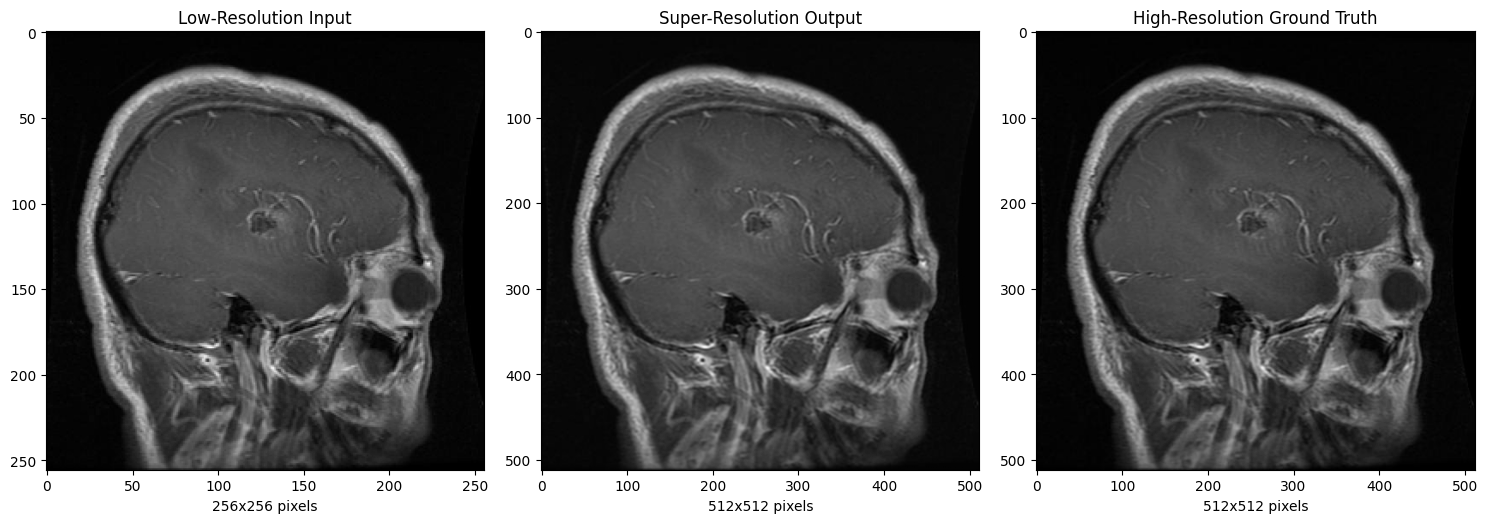

In [ ]:
import matplotlib.pyplot as plt

def plot_results(lr, sr, hr):
    plt.figure(figsize=(15, 5))

    lr_np = lr.squeeze(0).cpu().detach().numpy()
    sr_np = sr.squeeze(0).cpu().detach().numpy()
    hr_np = hr.squeeze(0).cpu().detach().numpy()

    plt.subplot(1, 3, 1)
    plt.title("Low-Resolution Input")
    plt.xlabel(f"{lr_np.shape[1]}x{lr_np.shape[0]} pixels")
    plt.imshow(lr_np, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Super-Resolution Output")
    plt.xlabel(f"{sr_np.shape[1]}x{sr_np.shape[0]} pixels")
    plt.imshow(sr_np, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("High-Resolution Ground Truth")
    plt.xlabel(f"{hr_np.shape[1]}x{hr_np.shape[0]} pixels")
    plt.imshow(hr_np, cmap='gray')

    plt.tight_layout()
    plt.show()


# Test on sample
model.eval()
sample_lr, sample_hr = next(iter(train_loader))
sample_sr = model(sample_lr.to(device)).cpu()

plot_results(sample_lr[0], sample_sr[0], sample_hr[0])